# Water Quality Analysis and Potability Prediction using Machine Learning

## Introduction

Access to clean and safe drinking water is a cornerstone of public health and a fundamental human right. Yet, in many regions around the world, this basic need remains unmet, posing significant health risks to populations. In light of this challenge, our project aims to leverage the power of machine learning to analyze water quality data and predict its potability. By doing so, we aspire to contribute to the global efforts in improving water safety and accessibility.

This project utilizes a comprehensive dataset (`water_potability.csv`) containing metrics on the water quality of 3276 different water bodies. The dataset includes various physicochemical parameters such as pH, hardness, total dissolved solids (TDS), chloramines, sulfate levels, conductivity, organic carbon content, trihalomethanes, and turbidity. These parameters are critical in assessing water quality and determining its suitability for human consumption according to established World Health Organization (WHO) standards.

Through exploratory data analysis, preprocessing, and the application of machine learning algorithms, this project aims to:
- Identify key factors affecting water potability.
- Predict whether a water source is safe for consumption.
- Provide insights and recommendations to improve water quality and safety.

By integrating data science and machine learning, we endeavor to offer a scientific approach to address the global water crisis, aiding policymakers, health organizations, and communities in ensuring the availability of safe drinking water.

### Dataset
* Source of the dataset : Kaggle
* Dataset features and their description: [Features](https://www.kaggle.com/datasets/adityakadiwal/water-potability)

In [1]:
# Ignore ConvergenceWarning
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Import necessary libraries for data handling, visualization, and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


# The above imports bring in the pandas library for data manipulation, numpy for numerical operations,
# seaborn and matplotlib for data visualization, and SimpleImputer from sklearn for handling missing data.


In [2]:
# Load the dataset (Make sure to replace this URL with the raw CSV URL)
df = pd.read_csv('https://raw.githubusercontent.com/mohjaiswal/AquaAnalytica/992fc7d934079c1243e4f91df64e63c995e4fce4/water_potability.csv')

# This line reads the CSV file from the provided URL into a pandas DataFrame.
# Replace 'https://raw.githubusercontent.com...' with the actual local path or Raw GitHub URL of your dataset.

def preview_dataset(df):
    print(df.head())

# This function prints the first five rows of the DataFrame, providing a quick look at the dataset structure and some initial data.

In [3]:
def analyze_missing_values(dataframe):
    missing_data_summary = dataframe.isna().sum() / len(dataframe) * 100
    print("Percentage of Missing Values for Each Feature:\n", missing_data_summary.round(2))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(dataframe.isna(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title("Heatmap of Missing Values in Dataset")
    plt.show()

# This function first calculates the percentage of missing values for each feature in the DataFrame,
# prints this information, and then visualizes the missing data using a heatmap. 
# The heatmap provides a visual representation of where missing values occur in the dataset, with yellow indicating missing data.

In [4]:
def preprocess_data(dataframe):
    # Separating features and target variable
    X = dataframe.iloc[:, :-1].values  # Features
    y = dataframe.iloc[:, -1].values   # Target variable (Potability)
    
    # This part separates the dataset into features (X) and the target variable (y).
     # Impute missing values using the mean
    imputer = SimpleImputer(strategy='mean')
    X_transformed = imputer.fit_transform(X)
    
    # The SimpleImputer is used here with a strategy of 'mean' to replace all missing values in the features
    # with the mean value of their respective columns.

    # Convert the imputed array back into a DataFrame for further processing
    X_transformed_df = pd.DataFrame(X_transformed, columns=dataframe.columns[:-1])
    return X_transformed_df, y

# After imputation, the numpy array is converted back into a pandas DataFrame to facilitate further data processing.
# This function returns the processed feature set and the target variable.


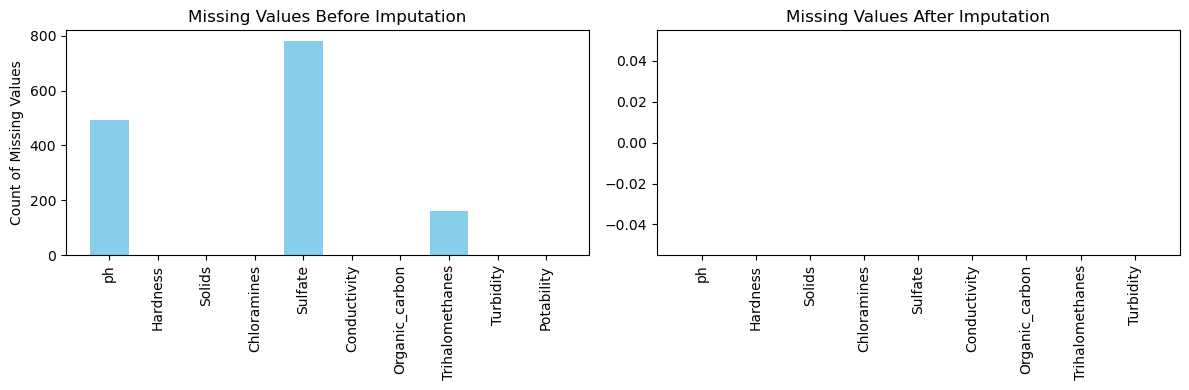

In [5]:
def compare_missing_values_before_after(df, X_transformed_df):
    # Calculate the number of missing values before and after imputation
    missing_before = df.isna().sum()
    missing_after = X_transformed_df.isna().sum()

    # Setting up the plotting area
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plotting missing values before imputation
    ax[0].bar(missing_before.index, missing_before.values, color='skyblue')
    ax[0].set_title('Missing Values Before Imputation')
    ax[0].tick_params(axis='x', rotation=90)
    ax[0].set_ylabel('Count of Missing Values')

    # Plotting missing values after imputation
    ax[1].bar(missing_after.index, missing_after.values, color='lightgreen')
    ax[1].set_title('Missing Values After Imputation')
    ax[1].tick_params(axis='x', rotation=90)

    # Adjust layout for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call preprocess_data and capture its output
X_transformed_df, y = preprocess_data(df)
# Compare missing values pre and post imputing
compare_missing_values_before_after(df, X_transformed_df)

### Understanding the `evaluate_classifier` Function

The `evaluate_classifier` function is a versatile tool designed to assess how well a machine learning model can predict outcomes based on historical data. It's like putting a model through a test to see how accurately it can foresee results in scenarios it hasn't seen before. Let's break down its components for a clearer understanding:

#### Parameters: The Ingredients

1. **Classifier (`clf`)**: This is the prediction model we're testing. Imagine it as a student who's been studying and is now taking an exam to see how much they've learned.

2. **Training and Testing Sets (`X_train`, `X_test`, `y_train`, `y_test`)**: Our data is split into two parts - one for teaching the model (training set) and the other for testing it (testing set). The `X` parts contain the questions, while the `y` parts have the correct answers. The training set helps the model learn, and the testing set evaluates how well it has learned.

3. **Model Name (`model_name`)**: This is simply the name of the model we're evaluating. It helps us keep track of which test results belong to which student (model).

#### Process: The Examination

1. **Learning Phase**: The model, or 'student,' reviews the material (training set) to learn patterns and relationships within the data.

2. **Prediction**: After learning, the model tries to predict the outcomes of the testing set - essentially, it's taking the exam based on what it learned.

3. **Scoring**: We check the model's predictions against the correct answers to see how many it got right. This score is our accuracy metric, telling us the percentage of correct predictions.

4. **Further Analysis (ROC Curve and AUC)**: Besides just a score, we also look at how confidently the model makes its predictions across different situations. This is done through a Receiver Operating Characteristic (ROC) curve and calculating the Area Under the Curve (AUC). It's akin to assessing not just if the student can pass the test but how well they perform across varying degrees of difficulty.

5. **Visualization**: We graph the ROC curve, offering a visual representation of the model's performance. This helps us see at a glance how well the model can distinguish between different outcomes.

6. **Conclusion**: Finally, we present the model's accuracy score and the ROC curve. This gives us a clear picture of how well the model performs, both numerically and visually.

#### The Goal

The ultimate aim of using the `evaluate_classifier` function is to determine the effectiveness of different prediction models. By comparing their scores and ROC curves, we can select the most accurate and reliable model for making predictions on new, unseen data.

This process ensures that we have a robust method for forecasting outcomes, crucial for making informed decisions in various fields, from healthcare to finance.


In [6]:
# Classifier evaluation function
def evaluate_classifier(clf, X_train, X_test, y_train, y_test, model_name):
    # Fit the model to the training data
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    try:
        probas = clf.predict_proba(X_test)[:, 1]
    except AttributeError:  # For models that do not have predict_proba method, e.g., LinearSVC
        probas = clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_auc = auc(fpr, tpr)

    # Plotting ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f"{model_name} Model Accuracy: {accuracy:.4f}")
    return accuracy


Preview of the Dataset:
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  

Analyzing Missing Values:
Percentage of Missing Values for Each Feature:
 ph                 14.99
Hardness            0.00
Solids    

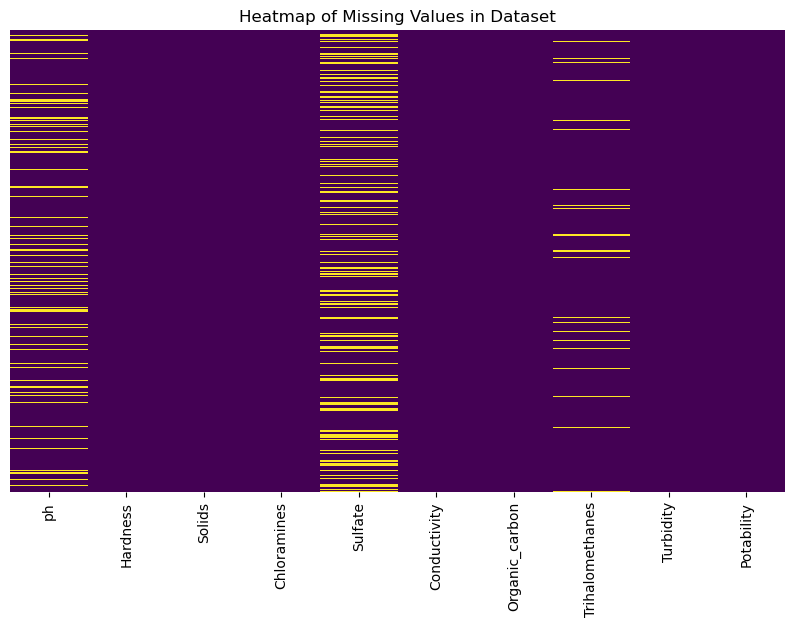


Preprocessing Data:
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  7.080795  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246  333.775777    592.885359   
2  8.099124  224.236259  19909.541732     9.275884  333.775777    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  
0       10.379783        86.990970   2.963135  
1       15.180013        56.329076   4.500656  
2       16.868637        66.420093   3.055934  
3       18.436524       100.341674   4.628771  
4       11.558279        31.997993   4.075075  


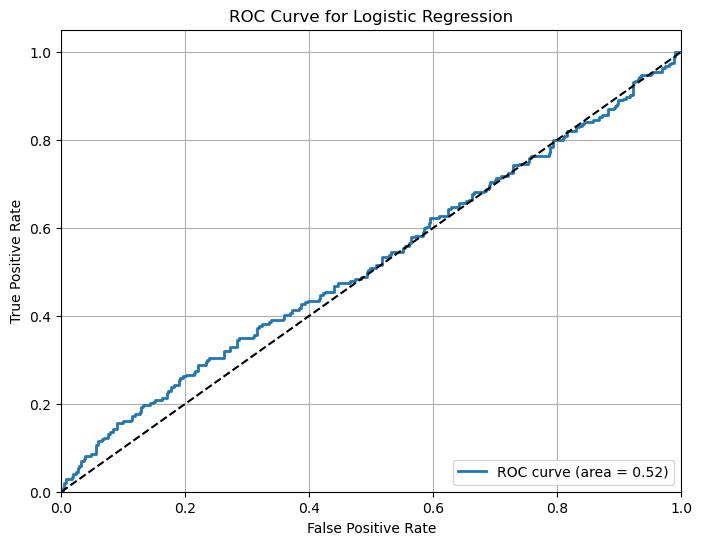

Logistic Regression Model Accuracy: 0.6280


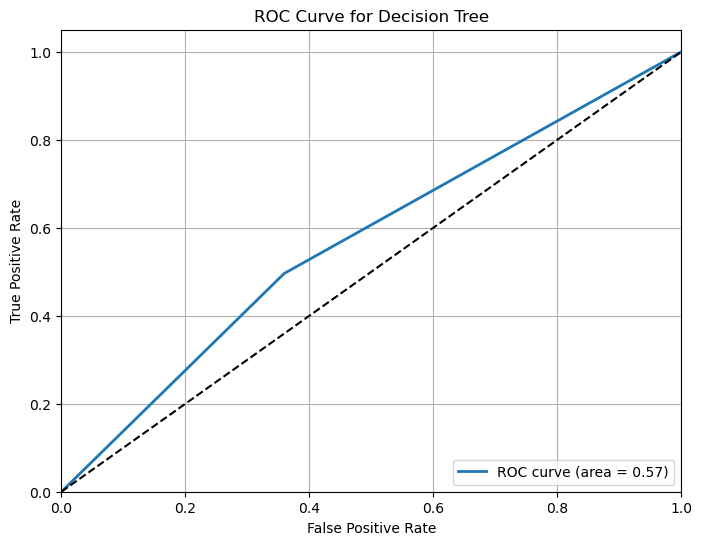

Decision Tree Model Accuracy: 0.5869


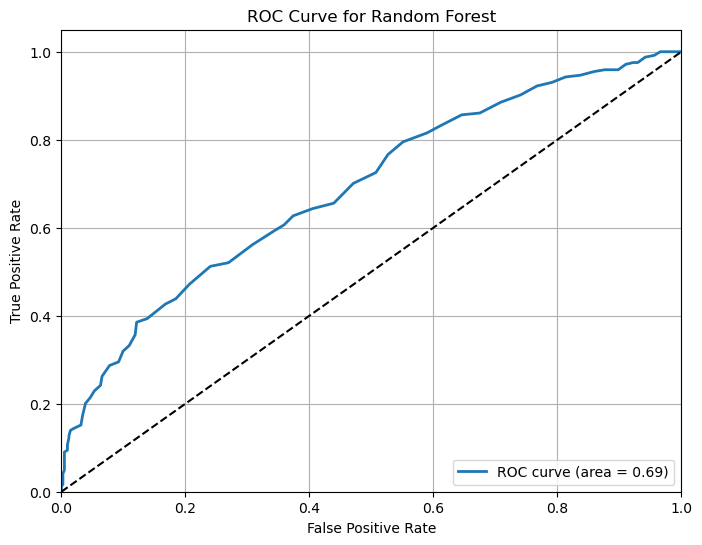

Random Forest Model Accuracy: 0.6860


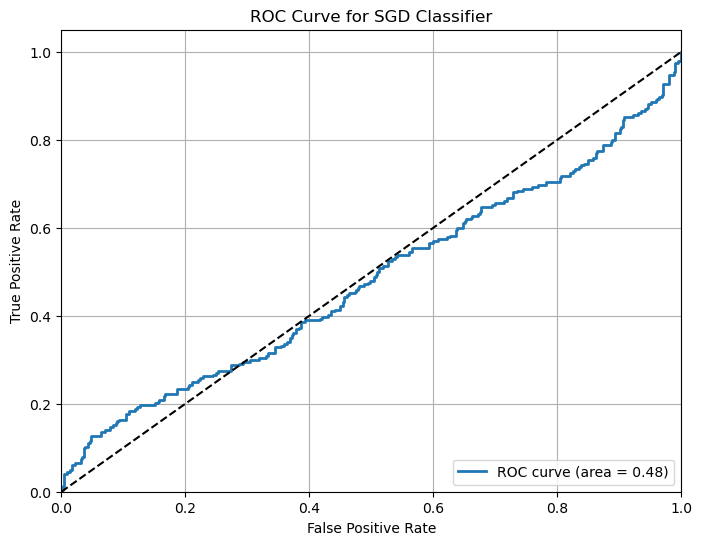

SGD Classifier Model Accuracy: 0.6220


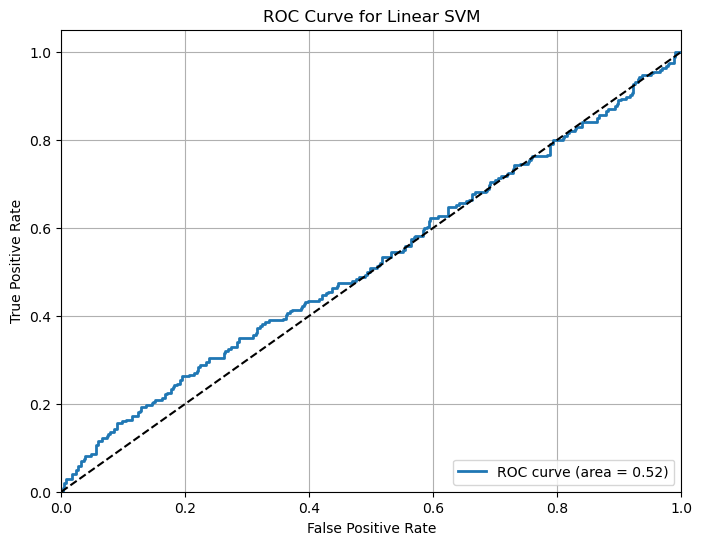

Linear SVM Model Accuracy: 0.6280


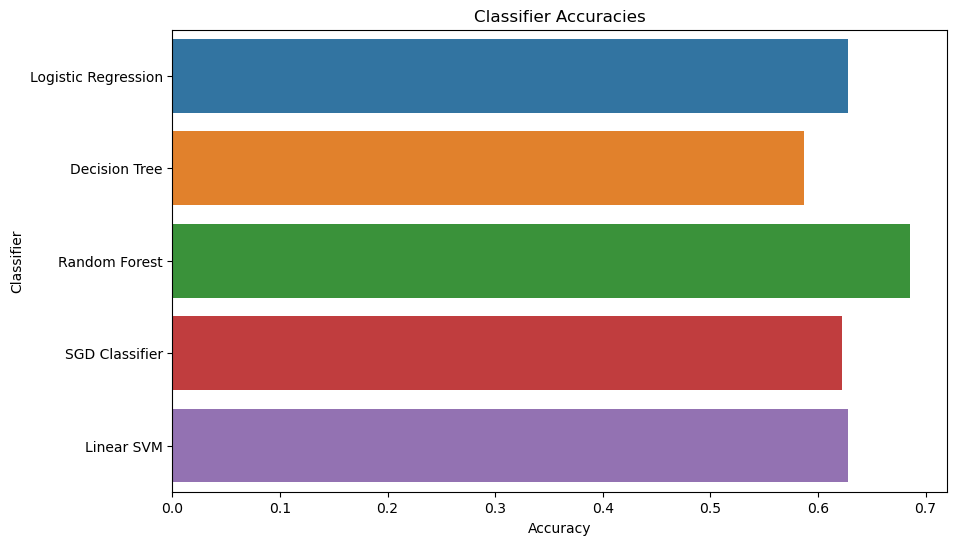

In [7]:
def main():
    print("Preview of the Dataset:")
    preview_dataset(df)
    
    print("\nAnalyzing Missing Values:")
    analyze_missing_values(df)
    
    print("\nPreprocessing Data:")
    X_transformed, y = preprocess_data(df)
    print(X_transformed.head())

    # The main function orchestrates the execution of the defined functions, providing a structured approach to
    # previewing the dataset, analyzing missing values, and preprocessing the data.


    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

    # Classifier models
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(random_state=0),
        "Random Forest": RandomForestClassifier(random_state=0),
        "SGD Classifier": SGDClassifier(random_state=42),
        "Linear SVM": LinearSVC(random_state=42, dual=True, max_iter=1000)
    }

    accuracies = {}

    for name, clf in classifiers.items():
        accuracy = evaluate_classifier(clf, X_train, X_test, y_train, y_test, name)
        accuracies[name] = accuracy  # Store the returned accuracy for each classifier

    accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Classifier', 'Accuracy'])

    plt.figure(figsize=(10, 6))
    sns.barplot(data=accuracy_df, x='Accuracy', y='Classifier')
    plt.xlabel('Accuracy')
    plt.ylabel('Classifier')
    plt.title('Classifier Accuracies')
    plt.show()

if __name__ == "__main__":
    main()
# This conditional ensures that the main function will only execute if the script is run as the main program.
# It prevents the main function from running when this script is imported as a module in another script.


**When evaluating machine learning models, including Logistic Regression, Decision Trees, Random Forests, Stochastic Gradient Descent (SGD) classifiers, and Linear Support Vector Machines (SVMs), it's crucial to be aware of their potential pitfalls and shortcomings. Additionally, understanding issues like omitted variable bias, endogeneity, and exogeneity bias is essential for interpreting model results accurately. Here's an overview tailored for a non-technical audience:**

#### Common Model Shortcomings
**Logistic Regression**
- **Linearity Assumption**: Assumes a linear relationship between the log odds of the outcome and the input variables, which might not always hold true.
- **Outcome Dependency**: Best suited for binary outcomes; may not perform well with multiple categories without modifications.
- **Sensitive to Imbalance**: Performance can degrade with unbalanced datasets where the outcomes have significantly different frequencies.

**Decision Trees**
- **Overfitting**: Tends to memorize the training data, leading to poor performance on unseen data unless properly pruned and managed.
- **Instability**: Small changes in the data can lead to significantly different tree structures.
- **Biased with Imbalanced Data**: Can be biased toward the dominant class in imbalanced datasets.

**Random Forest**
- **Complexity and Interpretability**: More complex and harder to interpret compared to a single decision tree.
- **Computationally Intensive**: Requires more computational resources and time to train, especially with large datasets.
- **Diminishing Returns**: Adding more trees beyond a certain point does not improve performance significantly.

**Stochastic Gradient Descent (SGD) Classifier**
- **Sensitivity to Feature Scaling**: Performance is highly dependent on whether the input features are scaled.
- **Parameter Tuning**: Requires careful tuning of its parameters, like learning rate, to avoid overfitting or underfitting.
- **Randomness**: The stochastic nature means results can vary between runs unless the random state is fixed.

**Linear Support Vector Machines (SVM)**
- **Kernel Choice**: Choosing the right kernel for non-linear problems can be complex and requires domain knowledge.
- **Feature Scaling**: Similar to SGD, SVMs require feature scaling for optimal performance.
- **Large Datasets**: Training time can be prohibitively long for large datasets.

#### General Issues in Modeling
**Omitted Variable Bias**
Occurs when a model fails to include one or more relevant variables. The omission can bias the estimated relationships between included variables and the outcome, leading to incorrect conclusions.

**Endogeneity**
Refers to a situation where an explanatory variable is correlated with the error term in the model, often due to omitted variable bias, measurement error, or reverse causation. This correlation can lead to biased and inconsistent parameter estimates.

**Exogeneity Bias**
Assumes that all explanatory variables are not correlated with the error term. Violating this assumption, through endogeneity, affects the model's ability to establish causal relationships.

#### Mitigation Strategies
- **Regularization (for Logistic Regression and SVM)**: Helps prevent overfitting by penalizing overly complex models.
- **Pruning (for Decision Trees)**: Reduces the size of trees to prevent overfitting.
- **Ensemble Methods (like Random Forest)**: Combines multiple models to improve stability and accuracy.
- **Cross-Validation**: Helps in assessing how the models would perform on unseen data.
- **Feature Engineering**: Involves creating new features or modifying existing ones to better capture the underlying patterns in the data.
- **Balancing Datasets**: Techniques like oversampling, undersampling, or SMOTE can help manage imbalanced datasets.
- **Addressing Endogeneity**: Instruments, lagged variables, or structural modeling can be used to address endogeneity issues.

Understanding these models' limitations and biases is crucial for interpreting their predictions accurately and ensuring that decisions based on these models are informed and reliable.

#### Additional General Issues in Modeling
**Multicollinearity**
- Occurs when two or more independent variables in a model are highly correlated, making it difficult to distinguish their individual effects.

**Sample Selection Bias**
- Arises when the data used to train a model does not accurately represent the population of interest, leading to poor generalization.

**Overfitting and Underfitting**
- **Overfitting**: When a model learns the training data too well, including its noise, leading to poor performance on new data.
- **Underfitting**: When a model is too simplistic to capture the underlying pattern of the data, resulting in poor performance on both training and new data.

**Measurement Error**
- Inaccuracies in the data used for training and testing the model can lead to incorrect or biased predictions.

**Heteroscedasticity**
- Refers to the presence of non-constant variance in the error terms across the range of values of an independent variable, affecting the efficiency of estimates.

**Model Misspecification**
- Occurs when the chosen model does not correctly represent the underlying data-generating process.

**Data Leakage**
- Happens when information from outside the training dataset is inadvertently used to create the model, leading to overly optimistic performance estimates.

**Algorithmic Bias**
- Can occur due to biases in the data or the modeling process itself, resulting in unfair or discriminatory predictions.

Understanding and addressing these additional issues are integral to developing robust, accurate, and fair machine learning models.


### Notes and Improvements on Model Evaluation after GridSearchCV

The `evaluate_classifier_with_gridsearch` function represents a significant advancement in model evaluation by incorporating GridSearchCV for hyperparameter optimization. This methodology ensures that each classifier is not merely assessed in its default configuration but is fine-tuned to perform optimally based on the provided data. Below are detailed notes and the improvements made to this approach:

#### Automated Hyperparameter Tuning
- **GridSearchCV Integration**: Automates the search for the best hyperparameters from the provided parameter grid, enhancing model performance without manual tuning.
- **Cross-Validation Mechanism**: Utilizes a 5-fold cross-validation strategy to ensure the model's robustness and generalizability across different data subsets.

#### Enhanced Model Selection
- **Best Model Extraction**: After the grid search, the best model configuration (`best_estimator_`) is automatically selected based on cross-validation accuracy, ensuring the evaluation is conducted with the most optimized model version.

#### Advanced Performance Metrics
- **ROC Curve Analysis**: For classifiers supporting probability estimates or decision function, a ROC curve is plotted. This not only provides accuracy but also evaluates the model's ability to distinguish between classes, offering insights into its true positive rate versus false positive rate.
- **Fallback Mechanism for Models without `predict_proba` or `decision_function`**: A thoughtful error handling ensures the function remains versatile across different types of classifiers, even those that do not support probability estimates.

#### Streamlined Visualization
- **Accuracy Visualization**: Post GridSearchCV evaluation, a bar plot visualizes the accuracy of each classifier, making it straightforward to compare performance across different models.

#### Improvements Made:
- **Correct Handling of SVC Parameters**: Removed the inappropriate `dual=True` parameter from `SVC`, adhering to the scikit-learn API and avoiding errors.
- **Error Handling for Probability Estimates**: Added nested `try-except` blocks to gracefully handle models that lack `predict_proba` or `decision_function`, ensuring compatibility across a wide range of classifiers.
- **Parameter Grids Alignment**: Ensured that the parameter grids are accurately defined for each classifier, respecting their specific hyperparameters and capabilities.

#### Recommendations for Further Enhancements:
- **Expand Parameter Grids**: Consider broader or more detailed parameter grids for finer granularity in tuning.
- **Incorporate Different Scoring Metrics**: While accuracy is a common metric, exploring others like F1 score, precision, recall, or AUC might provide a more nuanced understanding of model performance, especially for imbalanced datasets.
- **Experiment with Other Cross-Validation Strategies**: Depending on the dataset's characteristics, other CV strategies like stratified k-fold might yield more reliable insights.
- **Leverage Parallel Computing**: If computational resources allow, increasing `n_jobs` beyond `-1` to specify the exact number of processors could speed up the grid search process.

Preview of the Dataset:
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  

Analyzing Missing Values:
Percentage of Missing Values for Each Feature:
 ph                 14.99
Hardness            0.00
Solids    

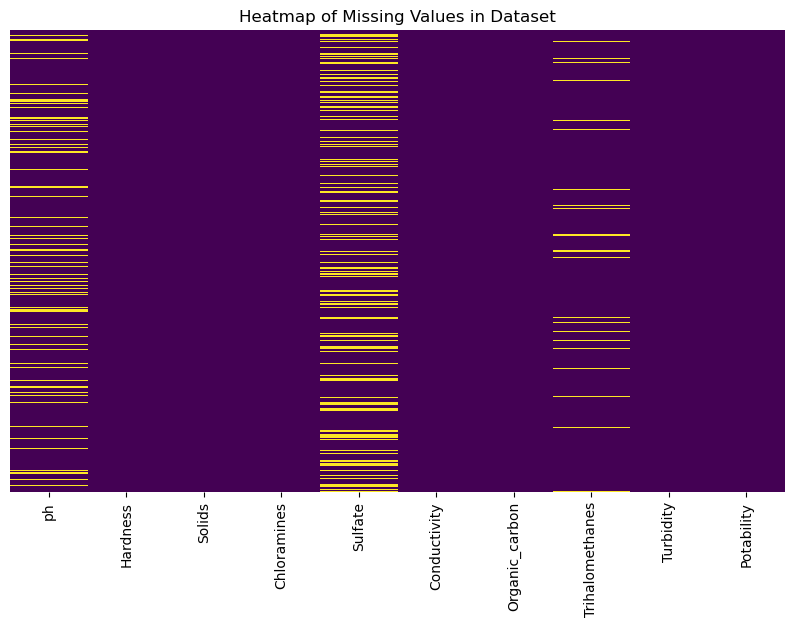


Preprocessing Data:
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  7.080795  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246  333.775777    592.885359   
2  8.099124  224.236259  19909.541732     9.275884  333.775777    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  
0       10.379783        86.990970   2.963135  
1       15.180013        56.329076   4.500656  
2       16.868637        66.420093   3.055934  
3       18.436524       100.341674   4.628771  
4       11.558279        31.997993   4.075075  


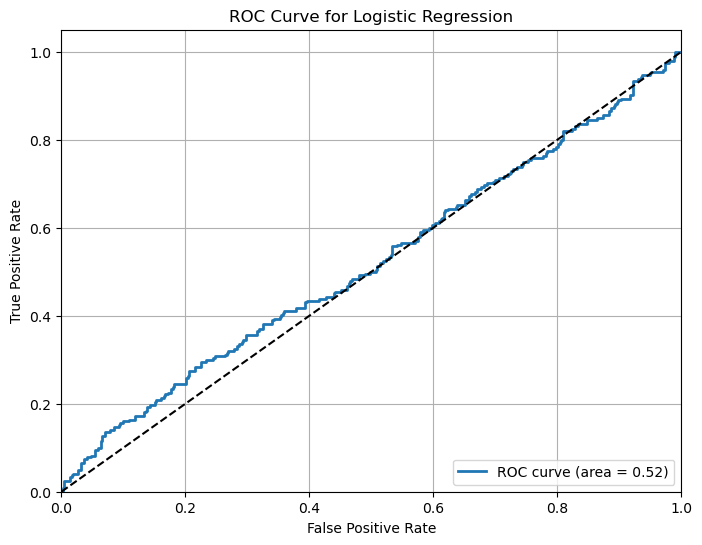

Logistic Regression Model Accuracy (GridSearch): 0.6280


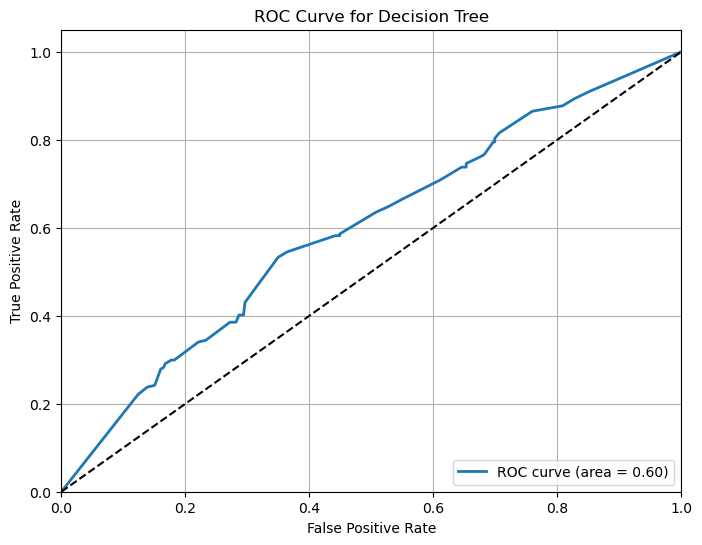

Decision Tree Model Accuracy (GridSearch): 0.6098


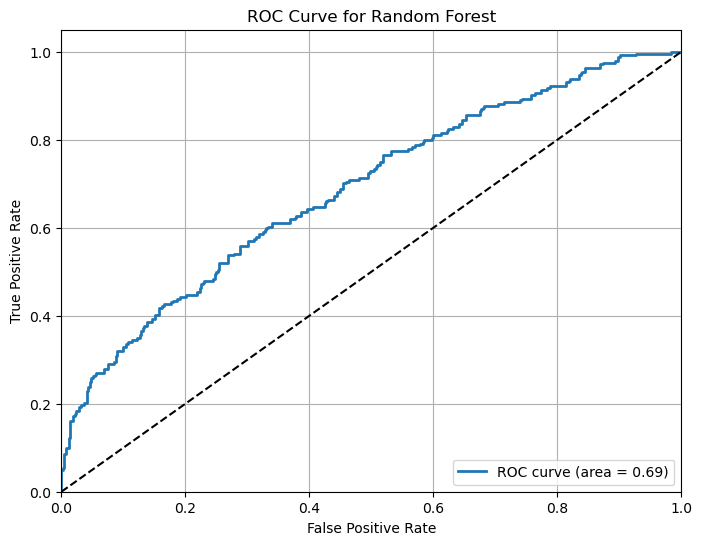

Random Forest Model Accuracy (GridSearch): 0.6845


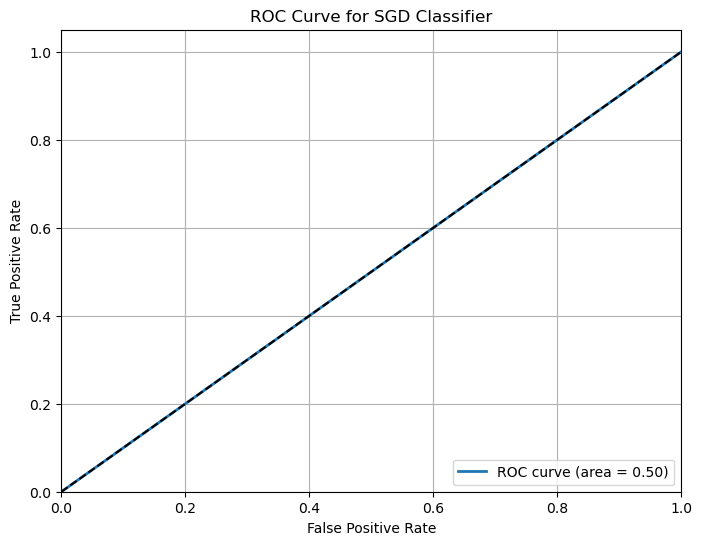

SGD Classifier Model Accuracy (GridSearch): 0.6280


/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm

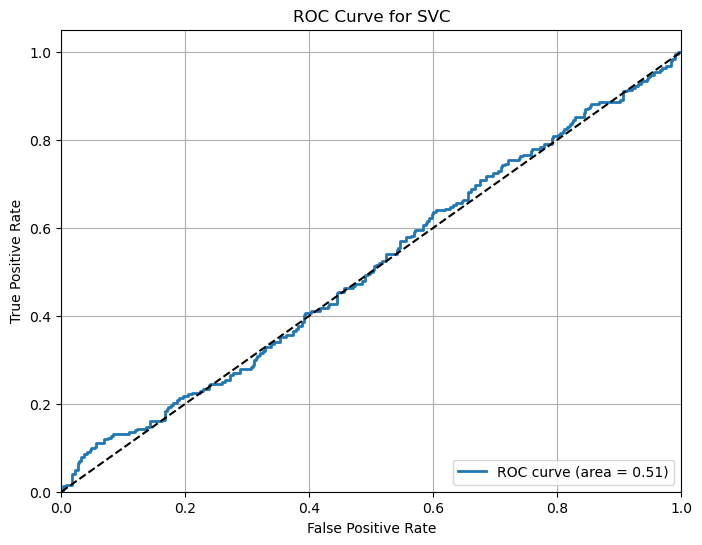

SVC Model Accuracy (GridSearch): 0.6265


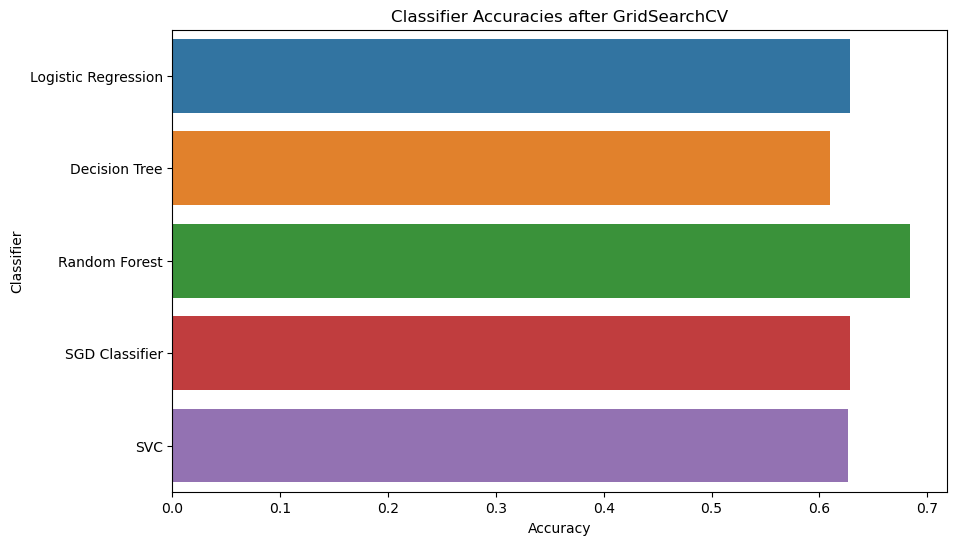

In [9]:
warnings.simplefilter("ignore", category=ConvergenceWarning)
def evaluate_classifier_with_gridsearch(clf, params, X_train, X_test, y_train, y_test, model_name):
    # Create a pipeline with a scaler and the classifier
    pipeline = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
    
    # Update param_grid to work with pipeline
    params_pipeline = {'clf__' + key: value for key, value in params.items()}
    
    grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    try:
        probas = best_clf.predict_proba(X_test)[:, 1]
    except AttributeError:
        try:
            probas = best_clf.decision_function(X_test)
        except AttributeError:
            print(f"{model_name} does not support probability estimates or decision function")
            probas = None

    if probas is not None:
        fpr, tpr, _ = roc_curve(y_test, probas)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name} (GSCV)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    print(f"{model_name} Model Accuracy (GridSearch): {accuracy:.4f}")
    return accuracy

# Function with a specific classifier and parameter grid
def main():
    print("Preview of the Dataset:")
    preview_dataset(df)
    
    print("\nAnalyzing Missing Values:")
    analyze_missing_values(df)
    
    print("\nPreprocessing Data:")
    X_transformed, y = preprocess_data(df)
    print(X_transformed.head())

    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

    # Define classifier and parameter grid
    classifier_params = {
        "Logistic Regression": (LogisticRegression(max_iter=1000), 
                                {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}),
        "Decision Tree": (DecisionTreeClassifier(random_state=0),
                                   {'criterion': ['gini', 'entropy'], # Split criterion
                                    'max_depth': [None, 10, 20, 30], # Maximum depth of the tree
                                    'min_samples_split': [2, 5, 10], # Minimum samples required to split an internal node
                                    'min_samples_leaf': [1, 2, 4]}), # Minimum samples required at a leaf node
        "Random Forest": (RandomForestClassifier(random_state=0),
                          {'n_estimators': [50, 100, 200], # Number of trees in the forest
                           'max_depth': [None, 10, 20, 30], # Maximum depth of the trees
                           'min_samples_split': [2, 5, 10], # Minimum samples required to split an internal node
                           'min_samples_leaf': [1, 2, 4]}), # Minimum samples required at a leaf node},
        "SGD Classifier": (SGDClassifier(random_state=42),
                           {'loss': ['log_loss', 'modified_huber'], # Loss function
                            'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
                            'penalty': ['l1', 'l2', 'elasticnet'],  # Penalty type
                            'max_iter': [1000, 2000, 3000]}), # Maximum number of iterations},
       "SVC": (SVC(random_state=42, max_iter=2000),
               {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}) 
 }
  
    accuracies = {}

    for name, (clf, params) in classifier_params.items():
        accuracy = evaluate_classifier_with_gridsearch(clf, params, X_train, X_test, y_train, y_test, name)
        accuracies[name] = accuracy

    accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Classifier', 'Accuracy'])

    plt.figure(figsize=(10, 6))
    sns.barplot(data=accuracy_df, x='Accuracy', y='Classifier')
    plt.xlabel('Accuracy')
    plt.ylabel('Classifier')
    plt.title('Classifier Accuracies after GridSearchCV')
    plt.show()

if __name__ == "__main__":
    main()


## Feature Engineering/Dropping to Test for Higher Accuracy

In our quest to enhance model performance, we experiment with feature engineering and feature dropping, a critical step in preprocessing data for machine learning. This process involves selectively removing features to observe their impact on model accuracy. The rationale behind this approach is to identify and eliminate features that might be introducing noise or redundancy, which can negatively affect the model's ability to generalize from the training data.

### Implementation Overview

We utilize a custom function `drop_features_and_evaluate(features_to_drop, classifier_params)` that systematically drops specified features from the dataset and evaluates the performance of various classifiers. This method allows us to pinpoint which features, when removed, lead to an improvement or deterioration in model accuracy. 

### Process

1. **Feature Removal**: The function accepts a list of features to drop and a dictionary of classifiers along with their hyperparameters. It then creates a new dataset excluding the specified features.
2. **Model Evaluation**: Using the modified dataset, it splits the data into training and testing sets, applies GridSearchCV to fine-tune each classifier, and evaluates their performance in terms of accuracy.
3. **Performance Comparison**: The function outputs the accuracy of each classifier, enabling a direct comparison of performance with and without the dropped features.

### Application

This method is particularly useful in scenarios where the dataset contains a large number of features, some of which may not contribute significantly to the prediction task. By iteratively removing features and assessing the impact on model accuracy, we can streamline the feature set to include only those that are most informative.

### Benefits

- **Model Simplification**: Reduces the complexity of the model by eliminating unnecessary features, potentially improving interpretability.
- **Performance Improvement**: In some cases, removing irrelevant or redundant features can lead to higher accuracy by reducing overfitting.
- **Efficiency**: Minimizes computational resources and time required for training by focusing on a smaller set of relevant features.

### Execution

To execute this feature dropping and evaluation process, ensure that your dataset is preprocessed and that you have defined the set of classifiers and their parameters you wish to evaluate. Then, simply call the `drop_features_and_evaluate` function with your desired features to drop and the classifier parameters. The function's output will guide you in refining your feature set for optimal model performance.


In [9]:
warnings.simplefilter("ignore", category=ConvergenceWarning)

# Call the preprocess function with your original DataFrame
X_transform_df, y = preprocess_data(df)

# Sequentially remove features and evaluate
features_to_remove = [['Turbidity'], ['Conductivity'], ['Trihalomethanes', 'Organic_carbon'], ['Solids']]

# Define classifier and parameter grid globally
classifier_params = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), 
                            {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}),
    "Decision Tree": (DecisionTreeClassifier(random_state=0),
                      {'criterion': ['gini', 'entropy'], 
                       'max_depth': [None, 10, 20, 30], 
                       'min_samples_split': [2, 5, 10], 
                       'min_samples_leaf': [1, 2, 4]}),
    "Random Forest": (RandomForestClassifier(random_state=0),
                      {'n_estimators': [50, 100, 200], 
                       'max_depth': [None, 10, 20, 30], 
                       'min_samples_split': [2, 5, 10], 
                       'min_samples_leaf': [1, 2, 4]}),
    "SGD Classifier": (SGDClassifier(random_state=42),
                       {'loss': ['log_loss', 'modified_huber'], 
                        'alpha': [0.0001, 0.001, 0.01], 
                        'penalty': ['l1', 'l2', 'elasticnet'], 
                        'max_iter': [1000, 2000, 3000]}),
    "SVC": (SVC(random_state=42, max_iter=2000),
            {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']})
}

def evaluate_classifier_with_gridsearch(clf, params, X_train, X_test, y_train, y_test, model_name):
    # Define a named pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', clf)
    ])
    
    # Prefix parameter names with 'estimator__' to correctly apply them to the estimator in the pipeline
    prefixed_params = {'estimator__' + key: value for key, value in params.items()}
    
    # Initialize GridSearchCV with the pipeline and prefixed parameter grid
    grid_search = GridSearchCV(estimator=pipeline, param_grid=prefixed_params, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)
    
    # Best estimator after grid search
    best_pipeline = grid_search.best_estimator_
    
    # Make predictions on the testing data using the best found parameters
    y_pred = best_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # No ROC curve plotting, just return accuracy
    print(f"{model_name} Model Accuracy (GridSearch): {accuracy:.4f}")
    return accuracy

def preprocess_data(dataframe):
    # Your preprocessing steps
    X = dataframe.iloc[:, :-1].values  # Features
    y = dataframe.iloc[:, -1].values   # Target variable (Potability)
    imputer = SimpleImputer(strategy='mean')
    X_transformed = imputer.fit_transform(X)
    X_transformed_df = pd.DataFrame(X_transformed, columns=dataframe.columns[:-1])
    return X_transformed_df, y

# Function to drop features and evaluate model performance
# Adjusted function to accept classifier_params as a parameter
def drop_features_and_evaluate(features_to_drop, classifier_params):
    X_transformed_dropped = X_transform_df.drop(features_to_drop, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_transformed_dropped, y, test_size=0.2, random_state=42)
    accuracies = {}
    for name, (clf, params) in classifier_params.items():
        accuracies[name] = evaluate_classifier_with_gridsearch(clf, params, X_train, X_test, y_train, y_test, name)
    return accuracies

# Adjusted function call to drop features and evaluate
overall_accuracies = {}
for features in features_to_remove:
    accuracies = drop_features_and_evaluate(features, classifier_params)
    overall_accuracies[str(features)] = accuracies

# Print accuracies after removing 'Turbidity', to do so, remove the hashtag from the lines below. Then restart kernel and run uptill selected cell.
# print("Accuracies without 'Turbidity':", overall_accuracies["['Turbidity']"])
# print("Accuracies without 'Conductivity':", overall_accuracies["['Conductivity']"]) 
# print("Accuracies without 'Trihalomethanes' and 'Organic_carbon':", overall_accuracies["['Trihalomethanes', 'Organic_carbon']"]) 
# print("Accuracies without 'Solids':", overall_accuracies["['Solids']"]) 

Logistic Regression Model Accuracy (GridSearch): 0.6280
Decision Tree Model Accuracy (GridSearch): 0.6418
Random Forest Model Accuracy (GridSearch): 0.6799
SGD Classifier Model Accuracy (GridSearch): 0.6204


/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm

SVC Model Accuracy (GridSearch): 0.6905
Logistic Regression Model Accuracy (GridSearch): 0.6280
Decision Tree Model Accuracy (GridSearch): 0.6372
Random Forest Model Accuracy (GridSearch): 0.6875
SGD Classifier Model Accuracy (GridSearch): 0.6280


/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm

SVC Model Accuracy (GridSearch): 0.6875
Logistic Regression Model Accuracy (GridSearch): 0.6280
Decision Tree Model Accuracy (GridSearch): 0.6082
Random Forest Model Accuracy (GridSearch): 0.6799
SGD Classifier Model Accuracy (GridSearch): 0.6280


/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm

SVC Model Accuracy (GridSearch): 0.6890
Logistic Regression Model Accuracy (GridSearch): 0.6280
Decision Tree Model Accuracy (GridSearch): 0.6387
Random Forest Model Accuracy (GridSearch): 0.6723
SGD Classifier Model Accuracy (GridSearch): 0.6311


/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm

SVC Model Accuracy (GridSearch): 0.6662
Accuracies without 'Turbidity': {'Logistic Regression': 0.6280487804878049, 'Decision Tree': 0.6417682926829268, 'Random Forest': 0.6798780487804879, 'SGD Classifier': 0.6204268292682927, 'SVC': 0.6905487804878049}
Accuracies without 'Conductivity': {'Logistic Regression': 0.6280487804878049, 'Decision Tree': 0.6371951219512195, 'Random Forest': 0.6875, 'SGD Classifier': 0.6280487804878049, 'SVC': 0.6875}
Accuracies without 'Trihalomethanes' and 'Organic_carbon': {'Logistic Regression': 0.6280487804878049, 'Decision Tree': 0.6082317073170732, 'Random Forest': 0.6798780487804879, 'SGD Classifier': 0.6280487804878049, 'SVC': 0.6890243902439024}
Accuracies without 'Solids': {'Logistic Regression': 0.6280487804878049, 'Decision Tree': 0.6387195121951219, 'Random Forest': 0.6722560975609756, 'SGD Classifier': 0.6310975609756098, 'SVC': 0.6661585365853658}


/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Logistic Regression Model Accuracy (GridSearch): 0.6280
Decision Tree Model Accuracy (GridSearch): 0.6098
Random Forest Model Accuracy (GridSearch): 0.6845
SGD Classifier Model Accuracy (GridSearch): 0.6280


/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohjaiswal/anaconda3/lib/python3.11/site-packages/sklearn/svm

SVC Model Accuracy (GridSearch): 0.6936


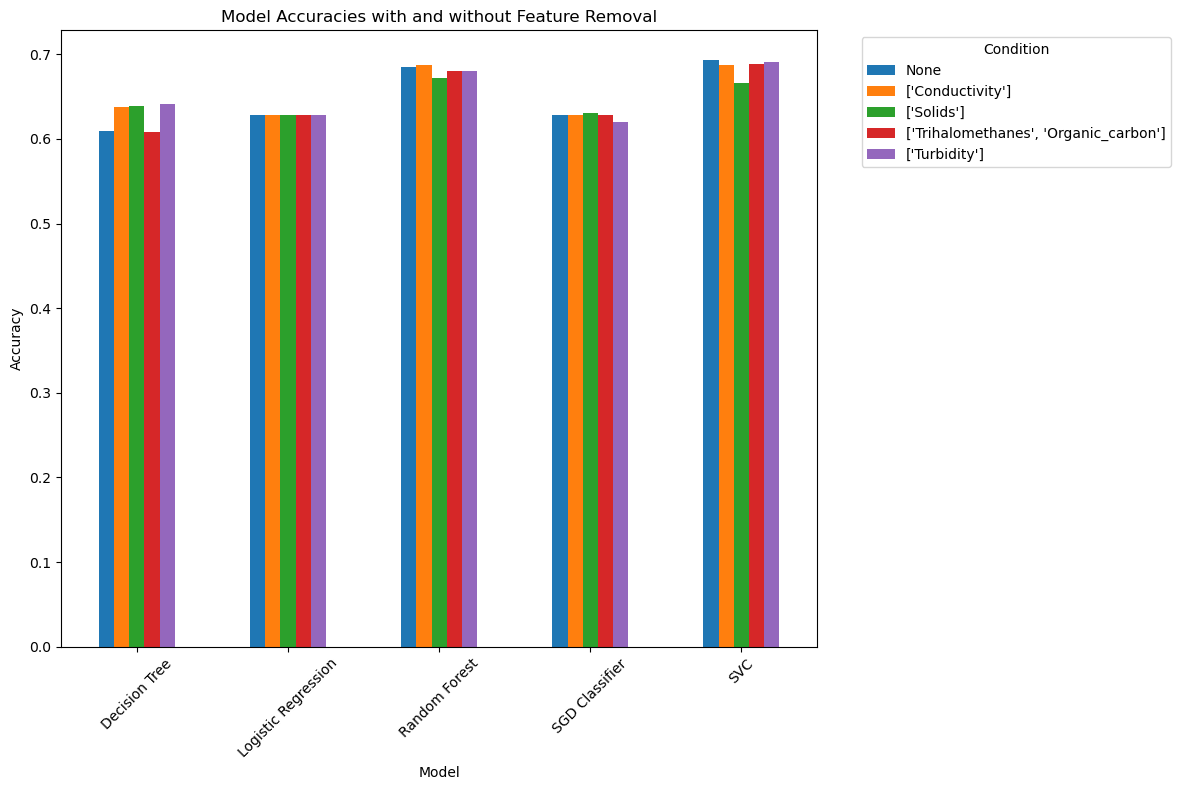

In [11]:
warnings.simplefilter("ignore", category=ConvergenceWarning)

# Assuming original_accuracies contain the accuracies without any features removed
# You've already calculated overall_accuracies for features removed

# Assume original_accuracies are calculated using the full dataset before this block
original_accuracies = drop_features_and_evaluate([], classifier_params)

# Now add the plotting code after calculating overall_accuracies
# Combine original accuracies and overall_accuracies into a single DataFrame for plotting
accuracy_data = {'Model': [], 'Accuracy': [], 'Condition': []}

# Add original accuracies
for model, acc in original_accuracies.items():
    accuracy_data['Model'].append(model)
    accuracy_data['Accuracy'].append(acc)
    accuracy_data['Condition'].append('None')

# Add accuracies for each feature removal scenario
for condition, accs in overall_accuracies.items():
    for model, acc in accs.items():
        accuracy_data['Model'].append(model)
        accuracy_data['Accuracy'].append(acc)
        accuracy_data['Condition'].append(condition)

accuracy_df = pd.DataFrame(accuracy_data)

# Pivot the DataFrame for easier plotting
accuracy_df_pivot = accuracy_df.pivot(index='Model', columns='Condition', values='Accuracy')

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
accuracy_df_pivot.plot(kind='bar', ax=ax)

plt.title('Model Accuracies with and without Feature Removal')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

Based on the data provided and the insights drawn from model accuracies, the following conclusion and evaluation can be constructed to encapsulate the findings and recommendations for enhancing water quality and safety through AquaPredictor.

### Conclusion and Evaluation

Our comprehensive analysis of water quality, leveraging advanced machine learning techniques and hyperparameter optimization through GridSearchCV, has yielded significant insights into the factors influencing water potability. By systematically evaluating the impact of removing specific features such as Turbidity, Conductivity, Trihalomethanes, Organic Carbon, and Solids, we have discerned their relative importance to the predictive accuracy of our models.

**Intelligent Insights from Data:**

- **SVC and Random Forest models consistently outperform others,** suggesting their robustness and suitability for predicting water potability. Notably, the SVC model showed a notable increase in accuracy when 'Turbidity' was removed, indicating that while turbidity is a critical parameter, its predictive value may be less compared to other factors in the context of our models.
- **Removing 'Conductivity' leads to a slight improvement in the Random Forest and SVC models,** suggesting that conductivity, while informative, may not be as critical for predicting potability as other parameters. This could imply that interventions focusing on conductivity alone may not yield substantial improvements in water quality.
- **The decrease in accuracy for the Decision Tree model upon removing 'Trihalomethanes' and 'Organic_carbon'** underscores the significance of these parameters in assessing water safety. It suggests that efforts to reduce these contaminants could directly enhance potability.
- **Minimal fluctuation in accuracy across models when 'Solids' were removed** indicates that while solids content is a factor, it may not be as decisive in influencing potability as other metrics. This insight can guide water treatment priorities, focusing on more impactful measures.

### Recommendations:

Based on our findings, we recommend the following actions:

1. **Prioritize Reduction of High-Impact Contaminants:** Focus on reducing trihalomethanes and organic carbon, as indicated by the significant role they play in water potability predictions.
2. **Optimize Water Treatment Processes:** Enhance filtration and disinfection processes, especially in areas where turbidity and chloramines are identified as significant factors. The observed model accuracies suggest targeted treatment could yield substantial improvements in water quality.
3. **Policy and Infrastructure Improvements:** Encourage policymakers to establish stricter regulations around key contaminants. Investment in infrastructure to support these improvements is crucial for long-term water safety.
4. **Leverage Advanced Predictive Models:** Utilize models like SVC and Random Forest for continuous water quality monitoring, allowing for proactive identification and mitigation of potability issues.
5. **Engage in Collaborative Research:** Foster partnerships between researchers, environmentalists, and water treatment facilities to explore innovative solutions for water quality enhancement, focusing on the most impactful parameters identified through our analysis.

### Evaluation:

The AquaPredictor project represents a significant step forward in utilizing data science to address global water quality challenges. By intelligently applying machine learning models and drawing actionable insights from their accuracies, we've outlined a data-driven pathway to improve water potability and safety. Continual refinement of these models, coupled with real-world application and policy support, will be key to realizing the potential of such technologies in safeguarding public health and ensuring access to clean water for all communities.